In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift, fftfreq

from skimage.feature import register_translation as phase_cross_correlation

import skimage
from scipy.interpolate import interp2d
#from scipy.ndimage import gaussian_filter

from scipy.optimize import minimize

# Registration using optimisation

Balci, Murat, et Hassan Foroosh. « Subpixel Registration Directly from the Phase Difference ». EURASIP Journal on Advances in Signal Processing 2006, nᵒ 1 (décembre 2006). https://doi.org/10.1155/ASP/2006/60796.


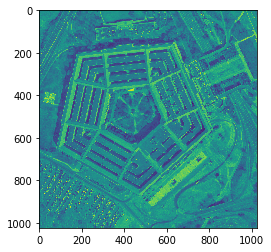

In [2]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
#image = gaussian_filter(image, sigma=5)
plt.imshow(image);

In [3]:
# Interpolation
#x_span, y_span = np.arange(image.shape[0]), np.arange(image.shape[1])
#x_grid, y_grid = np.meshgrid(x_span, y_span)

#f = interp2d(x_span, y_span, image, kind='cubic')

#x_A = np.arange(20, 281)
#y_A = np.arange(80, 232)a 

#dx, dy = (0.7512, 50.101512)
#A = f(x_A, y_A)
#B = f(x_A + dx, y_A + dy)  #+ 0.81*np.random.randn(*np.shape(A))

#plt.imshow(A - B);

In [4]:
# FFT shift interpolation
def fft_translate(A, dy, dx):
    a = fftn(A)
    kx = fftfreq(A.shape[0])
    ky = fftfreq(A.shape[1])
    k_xy = np.meshgrid(kx, ky, indexing='ij')

    b = a*np.exp(-1j*2*np.pi*(dx*k_xy[0] + dy*k_xy[1]))

    B = np.abs( ifftn(b) ) 
    return B

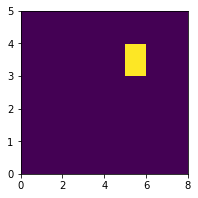

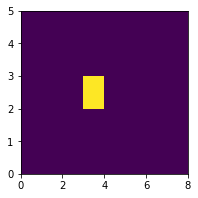

In [5]:
# test
A = np.zeros((5, 8))
A[3, 5] = 1

B = fft_translate(A, -2, -1)

plt.figure(figsize=(3, 3));
plt.pcolormesh(A)
plt.figure(figsize=(3, 3));
plt.pcolormesh(B)

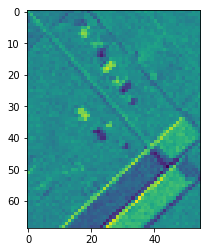

In [6]:
# Translate & Crop

dx, dy = 5.4, 6.6

x, y = 570, 551
Lx, Ly = 55, 69
A = image[y:y+Ly, x:x+Lx]
B = fft_translate(image, dx, dy)[y:y+Ly, x:x+Lx]
B += 0.05*np.random.randn(*B.shape)
plt.imshow(A-B);

In [7]:
from scipy.signal.windows import blackman

u = blackman(A.shape[0])[:, np.newaxis]
v = blackman(A.shape[1])[np.newaxis, :]
window = np.matmul(u, v)
#plt.imshow(window); plt.title('blackman window');

In [21]:
# ====================
#  Fourier Transform
# ====================
#window = 1
a = fftn(A*window)
b = fftn(B*window)

# cross-corr
upsamplefactor = 1
ab = a * b.conj()
ab = ab / np.abs(ab)
cross_corr =  np.abs( ifftn(fftshift(ab),
                            s=[s*upsamplefactor for s in ab.shape]) )
cross_corr = fftshift(cross_corr)

dx_span = fftshift( fftfreq(cross_corr.shape[1]) )*A.shape[1]
dy_span = fftshift( fftfreq(cross_corr.shape[0]) )*A.shape[0]

# argmax
argmax_idx = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
print(f"{argmax}")

(-7.0, -5.0)


In [22]:
# Verif  phase_cross_correlation
shifts, _, _ = phase_cross_correlation(A, B, upsample_factor=10)
print(shifts)

[-6.6 -5.4]


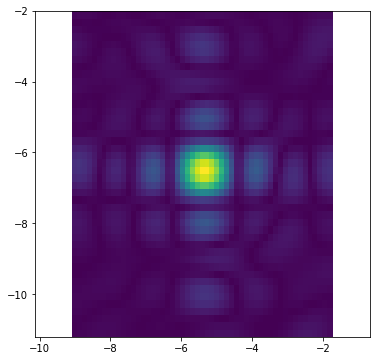

In [23]:
def custom_dft(data, x):
    x = x[::-1]
    upsample_factor=1 
    im2pi = 1j * 2 * np.pi

    dim_properties = list(zip(data.shape, x))
    for (n_items, ax_offset) in dim_properties[::-1]:
        kernel = ax_offset * fftfreq(n_items, upsample_factor)
        kernel = np.exp(im2pi * kernel)

        # Equivalent to:
        #   data[i, j, k] = kernel[i, :] @ data[j, k].T
        data = np.tensordot(kernel, data, axes=(0, -1))
        
    return data

# Verif. custom_dft
zoom_factor = 15
y_span = np.linspace(-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy, 45)
x_span = np.linspace(-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx, 54)

x_grid, y_grid = np.meshgrid(x_span, y_span)
x_flat, y_flat = x_grid.flatten(), y_grid.flatten()
xy = np.vstack([x_flat, y_flat]).T


dft = np.array( [np.abs( custom_dft(ab, xy_i) ) for xy_i in xy] )
dft = dft.reshape(x_grid.shape)

plt.figure(figsize=(6, 6))
plt.pcolormesh(x_span, y_span, dft); plt.axis('equal');

In [24]:
def cost(xy, ab):
    return -np.abs( custom_dft(ab, xy) )

res = minimize(cost, argmax[::-1], args=(ab, ), method='BFGS')
res

      fun: -2433.7863702830746
 hess_inv: array([[1.22884816e-04, 4.95479546e-07],
       [4.95479546e-07, 1.23382064e-04]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 7
     njev: 14
   status: 0
  success: True
        x: array([-5.39826067, -6.59935721])

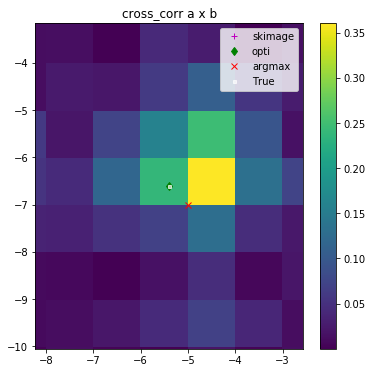

In [25]:
# cross_corr
plt.figure(figsize=(6, 6))
plt.pcolormesh(dx_span, dy_span, cross_corr, shading='flat');
plt.axis('equal')
plt.title('cross_corr a x b'); plt.colorbar();

zoom_factor = 20
plt.ylim([-A.shape[0]/zoom_factor - dy, +A.shape[0]/zoom_factor - dy ]);
plt.xlim([-A.shape[1]/zoom_factor - dx, +A.shape[1]/zoom_factor - dx]);

plt.plot(*shifts[::-1], '+m', label='skimage');
plt.plot(*res.x, 'dg', label='opti');
plt.plot(*argmax[::-1], 'xr', label='argmax');
plt.plot(-dx, -dy, 'sw', markersize=3, label='True', alpha=0.7);

plt.legend();plt.axvline(x=0, linestyle='--', color='white', alpha=0.5);
plt.axhline(y=0, linestyle='--', color='white', alpha=0.5);

In [ ]:
res.x

- actually similar to search max of the inverse transform (DFT)
- Faster than 2nd DFT ? (grid search)
    - according to Manuel Guizar-Sicairos no  
    but why ?  (python ?)
        
- error estimatin -> cov matrix... given by the optim

- cross-correlation (used)  vs phase-correlation
- windowing or not ?

windowing + phase seems to be best...

In [ ]:
# log FFT^2 
plt.imshow(np.log(np.abs(ab)**2));
plt.title('|a*b|^2'); plt.colorbar();

- fit (cos(phi), sin(phi)) instead of 
the peak summit quadratic, or phi%pi

- but non linear... so do the interpolation&fit directly--> high order transformation